In [2]:
import sys
sys.path.insert(0, "../")

import numpy as np
from pinnutils import *

import scipy.io as sio
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from torch.autograd import grad
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.optim.lr_scheduler import ExponentialLR

from scipy.interpolate import griddata
from itertools import product, combinations

from torch.optim.lr_scheduler import ExponentialLR, MultiStepLR
from tqdm import tqdm_notebook as tqdm 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seed 1
scale 6
method 0


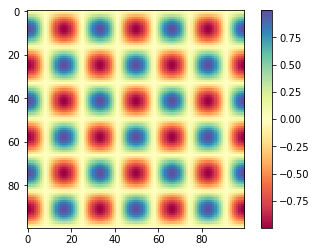

In [5]:
# experiment setup
scale  = 6
method = 0 # 0 - inverse dirichlet, 2 - maxavg, 3 - mgda, 4 - uniform, 5 - epsilon optimal
seed   = 1

print("seed", seed)
print("scale", scale)
print("method", method)

# genereate ground truth
def poisson_equation(x,y,omega):
    return np.cos(omega*x)*np.sin(omega*y)

x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)

omega = scale*np.pi
xx,yy = np.meshgrid(x,y)
u_sol = poisson_equation(xx,yy,omega)

plt.imshow(u_sol, cmap="Spectral")
plt.colorbar()

# generate training data
X = np.vstack([xx.ravel(), yy.ravel()]).T

yt = np.zeros((u_sol.size, 1), dtype=np.float)
for i,_x in enumerate(u_sol.real.T):
    yt[i*len(x):(i+1)*len(x)] = _x.reshape(len(x),1)

xb = np.linspace(0,1,100)
yb = np.linspace(0,1,100)

# X boundaries
lb   = np.min(xb)*np.ones((yb.shape))
Xlb  = np.vstack((lb,yb)).T
UXlb = np.cos(omega*Xlb[:,0])*np.sin(omega*Xlb[:,1])

rb   = np.max(xb)*np.ones((yb.shape))
Xrb  = np.vstack((rb,yb)).T
UXrb = np.cos(omega*Xrb[:,0])*np.sin(omega*Xrb[:,1])
    
# Y boundaries
lb   = np.min(yb)*np.ones((xb.shape))
Ylb  = np.vstack((xb,lb)).T
UYlb = np.cos(omega*Ylb[:,0])*np.sin(omega*Ylb[:,1])
    
rb   = np.max(yb)*np.ones((xb.shape))
Yrb  = np.vstack((xb,rb)).T
UYrb = np.cos(omega*Yrb[:,0])*np.sin(omega*Yrb[:,1])

seedc = seed
np.random.seed(seedc)
torch.manual_seed(seedc)

# training tensors
idxs = np.random.choice(yt.size, 2500, replace=False)
X_train = torch.tensor(X[idxs], dtype=torch.float32, requires_grad=True,device=device)
y_train = torch.tensor(yt[idxs], dtype=torch.float32, device=device)

X_rb = torch.tensor(Xrb, dtype=torch.float32, device=device)
X_lb = torch.tensor(Xlb, dtype=torch.float32, device=device)

Y_rb = torch.tensor(Yrb, dtype=torch.float32, device=device)
Y_lb = torch.tensor(Ylb, dtype=torch.float32, device=device)

U_X_rb = torch.tensor(UXrb, dtype=torch.float32, device=device).reshape(100,1)
U_X_lb = torch.tensor(UXlb, dtype=torch.float32, device=device).reshape(100,1)
U_Y_rb = torch.tensor(UYrb, dtype=torch.float32, device=device).reshape(100,1)
U_Y_lb = torch.tensor(UYlb, dtype=torch.float32, device=device).reshape(100,1)

TD = np.concatenate([X[idxs], Xrb, Xlb, Yrb, Ylb], 0)

# compute mean and std of training data
X_mean = torch.tensor(np.mean(TD, axis=0, keepdims=True), dtype=torch.float32, device=device)
X_std  = torch.tensor(np.std(TD, axis=0, keepdims=True), dtype=torch.float32, device=device)

In [6]:
# computes pde residual
def poisson_res(uhat, data, omega):
    poly = torch.ones_like(uhat)
    
    du = grad(outputs=uhat, inputs=data, 
              grad_outputs=torch.ones_like(uhat), create_graph=True)[0]
    
    dudx = du[:,0:1]
    dudy = du[:,1:2]
    
    dudxx = grad(outputs=dudx, inputs=data, 
              grad_outputs=torch.ones_like(uhat), create_graph=True)[0][:,0:1]
    dudyy = grad(outputs=dudy, inputs=data, 
              grad_outputs=torch.ones_like(uhat), create_graph=True)[0][:,1:2]
    
    xin = data[:,0:1]
    yin = data[:,1:2]
    
    source = -2.0*omega*omega*torch.cos(omega*xin)*torch.sin(omega*yin) + 0*uhat
    
    residual = dudxx + dudyy - source
                
    return residual

In [9]:
# setup neural network and training loop
net = PINNNoWN(sizes=[2,50,50,50,50,50,1], mean=X_mean, std=X_std, seed=seedc, activation=torch.nn.Tanh()).to(device)
print("#parameters:", sum(p.numel() for p in net.parameters() if p.requires_grad))

n_epochs   = 30_001
lamb       = 1
alpha_ann  = 0.5
mm         = 5
losses_bc  = [];
losses_reg = [];
lambs      = [];

params = [{'params': net.parameters(), 'lr': 1e-3}]
milestones = [[10000,20000,30000]]
optimizer = Adam(params)
scheduler = MultiStepLR(optimizer, milestones[0], gamma=0.1)

print("training with shape", X_train.size())

import time

start_time = time.time()
c_    = None
lamb  = 1
for epoch in range(n_epochs):
    grads_r = []
    grads_b = []
    
    optimizer.zero_grad()
    uhat  = net(X_train)
    res   = poisson_res(uhat, X_train, omega)
    l_reg = torch.mean((res)**2)
    
    stdr  = 0
    maxr  = 0
    G_reg = 0
    with torch.no_grad():
        if epoch % mm == 0:
            if method == 0:
                stdr = loss_grad_std_full(l_reg, net)
            if method == 2:
                maxr, _ = loss_grad_max_full(l_reg, net)
            if method == 3:
                G_reg = network_gradient(l_reg, net)
                
    predl = net(X_lb)
    predr = net(X_rb)
    l_bc  = torch.mean((predl - U_X_lb)**2, dim=0)
    l_bc += torch.mean((predr - U_X_rb)**2, dim=0)
 
    predl = net(Y_lb)
    predr = net(Y_rb)
    l_bc += torch.mean((predl - U_Y_lb)**2, dim=0)
    l_bc += torch.mean((predr - U_Y_rb)**2, dim=0)
    
    with torch.no_grad():
        if epoch % mm == 0:
            if method == 0:
                # inverse dirichlet
                stdb = loss_grad_std_full(l_bc, net)
                lamb_hat = stdr/stdb
                lamb     = (1-alpha_ann)*lamb + alpha_ann*lamb_hat
                lambs.append(lamb.item())
            elif method == 2:
                # max/avg
                _, meanu = loss_grad_max_full(l_bc, net, lambg=lamb)    
                lamb_hat = maxr/meanu
                lamb     = (1-alpha_ann)*lamb + alpha_ann*lamb_hat
                lambs.append(lamb.item()) 
            elif method == 5:
                # epsilon optimal
                optimal_lamb = 1.0/(1.0 + omega**4)
            elif method == 3:
                # mgda
                G_bc = network_gradient(l_bc, net)
                        
                # construct gradient matrix
                M = torch.zeros((torch.numel(G_reg), 2), dtype=torch.float32, device=device)
                        
                M[:,0] = G_reg
                M[:,1] = G_bc
                        
                # solve for optimal parameters
                c_ = solver_mine(torch.matmul(M.T, M).cpu().numpy(), 2, 1e-5, maxiter=1000)
                lambs.append([c_[0].item(), c_[1].item()])
            else:
                # uniform
                lamb = 1;

    if(method == 4):
        loss = l_reg + l_bc
    elif(method == 0 or method == 2):
        loss = l_reg + lamb*l_bc
    elif(method==5):
        loss = optimal_lamb*l_reg + (1.0 - optimal_lamb)*l_bc
    elif(method==3):
        loss = c_[0]*l_reg + c_[1]*l_bc

    losses_bc.append(l_bc.item())
    losses_reg.append(l_reg.item())
    
    loss.backward()

    optimizer.step()
    scheduler.step()
    
    print("epoch {}/{}, loss={:.10f}, lambda={:.4f}, lr={:,.5f}\t\t\t"
          .format(epoch+1, n_epochs, loss.item(), lamb, optimizer.param_groups[0]['lr']), end="\r")
        
elapsed_time = time.time() - start_time
print('CPU time = ',elapsed_time)

#parameters: 10401
training with shape torch.Size([2500, 2])


KeyboardInterrupt: 

pred rel. l2-error = 7.110190e-03


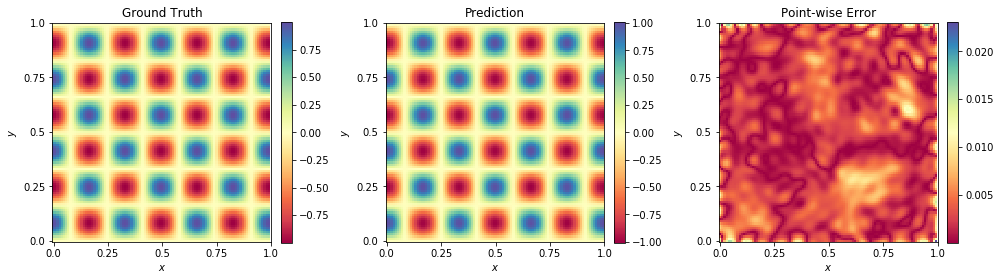

In [10]:
inp = torch.tensor(X, dtype=torch.float32, device=device)
out = net(inp).cpu().data.numpy().reshape(u_sol.shape)

print("pred rel. l2-error = {:e}".format(np.linalg.norm(out.reshape(-1)-u_sol.reshape(-1))/np.linalg.norm(out.reshape(-1))))

plt.subplot(1,3,1)
plt.imshow(u_sol, cmap="Spectral", origin="bottom")
plt.xticks(np.arange(0,len(x)+1,25), np.arange(0, 1.1, 0.25))
plt.yticks(np.arange(0,len(y)+1,25), np.arange(0, 1.1, 0.25))
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title("Ground Truth")
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(1,3,2)
plt.imshow(out, cmap="Spectral", origin="bottom")
plt.xticks(np.arange(0,len(x)+1,25), np.arange(0, 1.1, 0.25))
plt.yticks(np.arange(0,len(y)+1,25), np.arange(0, 1.1, 0.25))
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title("Prediction")
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(1,3,3)
plt.imshow(np.abs(out-u_sol)/np.max(np.abs(u_sol)), cmap="Spectral", origin="bottom")
plt.xticks(np.arange(0,len(x)+1,25), np.arange(0, 1.1, 0.25))
plt.yticks(np.arange(0,len(y)+1,25), np.arange(0, 1.1, 0.25))
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title("Point-wise Error")
plt.colorbar(fraction=0.046, pad=0.04)

plt.gcf().set_size_inches(14,4)
plt.tight_layout()